# Tugas Individu - Rekayasa Fitur
10122099<br>
Muhammad Raffy Abdillah<br>
IF-3<br>
Rekayasa Fitur Data Video<br>


Tahap 1: Import Pustaka dan Video

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
video = 'Kereta.mp4'

Tahap 2: Menampilkan Video

In [4]:
file_vid = cv2.VideoCapture(video)

while True:
    berhasil, bingkai = file_vid.read()
    if not berhasil:
        break
    cv2.imshow('Video Asli', bingkai)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

file_vid.release()
cv2.destroyAllWindows()

Tahap 3: Praproses (Resize & Grayscale)

In [5]:
file_vid = cv2.VideoCapture(video)

fps = file_vid.get(cv2.CAP_PROP_FPS)
print(f"FPS Video: {fps}")
berhasil, bingkai = file_vid.read()
tinggi, lebar = bingkai.shape[:2]

skala = 50
lebar_vid = int(lebar * skala / 100)
tinggi_vid = int(tinggi * skala / 100)

delay = int (500 / fps)

while True:
    berhasil, bingkai = file_vid.read()
    if not berhasil:
        file_vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
        continue
    ukuran = cv2.resize(bingkai, (lebar_vid, tinggi_vid))

    vid_abu = cv2.cvtColor(ukuran, cv2.COLOR_BGR2GRAY)

    cv2.imshow('Video Berubah Ukuran & Grayscale', vid_abu)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

file_vid.release()
cv2.destroyAllWindows()

FPS Video: 30.181098386723857


Tahap 4a: Ekstraksi Fitur (Frame Differencing)

In [6]:
file_vid = cv2.VideoCapture(video)

berhasil, bingkai = file_vid.read()
tinggi, lebar = bingkai.shape[:2]

skala = 50
lebar_vid = int(lebar * skala / 100)
tinggi_vid = int(tinggi * skala / 100)

prev_gray = None
frame_diff = []

while True:
    berhasil, bingkai = file_vid.read()
    if not berhasil:
        break

    ukuran = cv2.resize(bingkai, (lebar_vid, tinggi_vid))
    vid_abu = cv2.cvtColor(ukuran, cv2.COLOR_BGR2GRAY)

    if prev_gray is not None:
        diff = cv2.absdiff(vid_abu, prev_gray)
        _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

        score = np.sum(thresh) / 255
        frame_diff .append(score)

        cv2.imshow('Frame Differencing', thresh)

    prev_gray = vid_abu.copy()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

file_vid.release()
cv2.destroyAllWindows()

df = pd.DataFrame({'Jumlah Tepi Piksel': frame_diff})
df.to_csv('frame_differencing.csv', index=False)

Tahap 4b: Ekstraksi Fitur (Motion History Image)

In [ ]:
def grid_pooling(mhi_img, grid=(4,4)):
    h, w = mhi_img.shape
    gh, gw = grid
    result = []
    for y in range(gh):
        for x in range(gw):
            y1 = y * h // gh
            y2 = (y + 1) * h // gh
            x1 = x * w // gw
            x2 = (x + 1) * w // gw
            block = mhi_img[y1:y2, x1:x2]
            result.append(np.mean(block))
    return np.array(result)

In [8]:
file_vid = cv2.VideoCapture(video)

berhasil, bingkai = file_vid.read()
tinggi, lebar = bingkai.shape[:2]

skala = 50
lebar_vid = int(lebar * skala / 100)
tinggi_vid = int(tinggi * skala / 100)

prev_gray = None
mhi = np.zeros((tinggi_vid, lebar_vid), dtype=np.float32)
durasi = 59
timestamp = 0

fitur_mhi = []

while True:
    berhasil, bingkai = file_vid.read()
    if not berhasil:
        break 

    ukuran = cv2.resize(bingkai, (lebar_vid, tinggi_vid))
    vid_abu = cv2.cvtColor(ukuran, cv2.COLOR_BGR2GRAY)

    if prev_gray is not None:
        diff = cv2.absdiff(vid_abu, prev_gray)
        _, motion_mask = cv2.threshold(diff, 25, 1, cv2.THRESH_BINARY)

        timestamp += 1
        mhi[motion_mask == 1] = timestamp
        mhi[motion_mask == 0] -= 1
        mhi[mhi < (timestamp-durasi)] = 0

        mhi_disp = np.uint8(np.clip((mhi - (timestamp- durasi)) / durasi * 255, 0, 255))

        mhi_vector = grid_pooling(mhi_disp, grid=(4, 4))
        fitur_mhi.append(mhi_vector)

        cv2.imshow('MHI', mhi_disp)

    prev_gray = vid_abu.copy()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

file_vid.release()
cv2. destroyAllWindows()

fitur_mhi = np.array(fitur_mhi)
df_fitur = pd.DataFrame(fitur_mhi)
df_fitur.to_csv("fitur_mhi.csv", index=False)

In [18]:
file_vid = cv2.VideoCapture(video)

berhasil, bingkai = file_vid.read()
tinggi, lebar = bingkai.shape[:2]

skala = 50
lebar_vid = int(lebar * skala / 100)
tinggi_vid = int(tinggi * skala / 100)

prev_gray = None
mhi = np.zeros((tinggi_vid, lebar_vid), dtype=np.float32)
durasi = 100
timestamp = 0

file_vid.set(cv2.CAP_PROP_POS_FRAMES, 0)

while True:
    berhasil, bingkai = file_vid.read()
    if not berhasil:
        break

    ukuran = cv2.resize(bingkai, (lebar_vid, tinggi_vid))
    vid_abu = cv2.cvtColor(ukuran, cv2.COLOR_BGR2GRAY)

    if prev_gray is not None:
        # Frame Differencing
        diff = cv2.absdiff(vid_abu, prev_gray)
        _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
        diff_bgr = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

        # MHI
        _, motion_mask = cv2.threshold(diff, 25, 1, cv2.THRESH_BINARY)
        timestamp += 1
        mhi[motion_mask == 1] = timestamp
        mhi[motion_mask == 0] -= 1
        mhi[mhi < (timestamp - durasi)] = 0
        mhi_disp = np.uint8(np.clip((mhi - (timestamp - durasi)) / durasi * 255, 0, 255))
        mhi_bgr = cv2.cvtColor(mhi_disp, cv2.COLOR_GRAY2BGR)

        gabung = np.hstack((diff_bgr, mhi_bgr))
        cv2.imshow('Gabungan Frame Diff + MHI', gabung)

    prev_gray = vid_abu.copy()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

file_vid.release()
cv2.destroyAllWindows()

Tahap 5: Hasil Visual

Plot Perbandingan Gerakan Frame Differencing dengan MHI

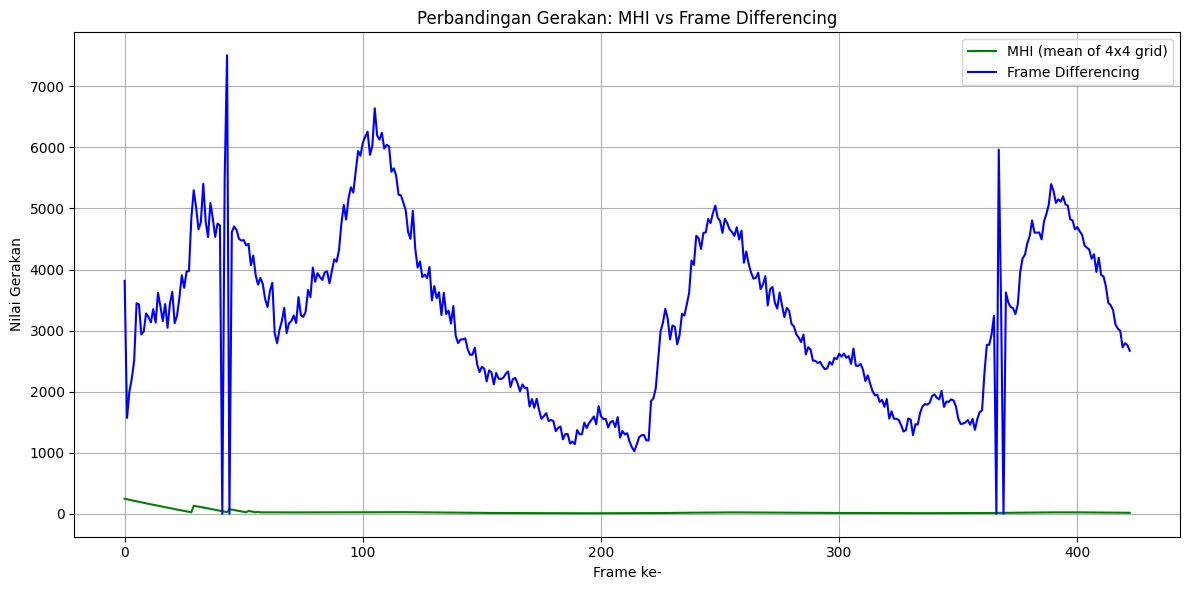

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_mhi = pd.read_csv("fitur_mhi.csv")
mhi_mean_per_frame = df_mhi.mean(axis=1)

df_diff = pd.read_csv("frame_differencing.csv")
diff_values = df_diff.iloc[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(mhi_mean_per_frame, label='MHI (mean of 4x4 grid)', color='green')

if len(mhi_mean_per_frame) == len(diff_values):
    plt.plot(diff_values, label='Frame Differencing', color='blue')

plt.title("Perbandingan Gerakan: MHI vs Frame Differencing")
plt.xlabel("Frame ke-")
plt.ylabel("Nilai Gerakan")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Plot Perbandingan Intensitas Gerakan MHI setiap Grid

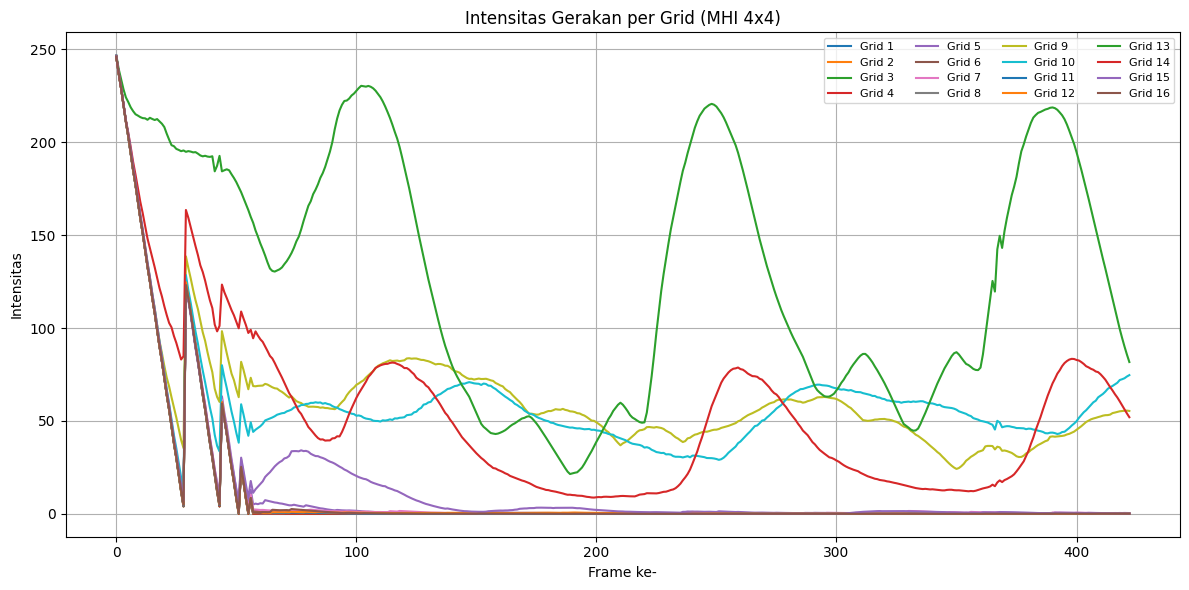

In [16]:
plt.figure(figsize=(12, 6))
for i in range(df_mhi.shape[1]):
    plt.plot(df_mhi.iloc[:, i], label=f'Grid {i+1}')
plt.title("Intensitas Gerakan per Grid (MHI 4x4)")
plt.xlabel("Frame ke-")
plt.ylabel("Intensitas")
plt.legend(ncol=4, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()